## ML II ASSIGNMENT - RANDOM FORESTS 
-----


In [1]:
# import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_text
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from sklearn.inspection import permutation_importance

from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

# others
from mltools import model_tools as MT

### Prepare and Explore the Data

In [2]:
# Load file with the dataset
df = pd.read_csv('data/dataset_final.csv', sep = ",")
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,FECHA,UTIL,IRRAD,ANNO,DIA,DIASEM,MES,TRAMO
0,2015-01-01 00:00:00,0.000003,0.0,2015,1,3,1,0
1,2015-01-01 03:00:00,0.000006,0.0,2015,1,3,1,3
2,2015-01-01 06:00:00,0.067728,0.0,2015,1,3,1,6
3,2015-01-01 09:00:00,0.611120,760335.4,2015,1,3,1,9
4,2015-01-01 12:00:00,0.660956,1565422.5,2015,1,3,1,12


We do a short recap of the data and the features we have in the dataset. This would be complementary to the EDA done in the previous notebook.
<!-- Esto es complemento de lo que ya teniamos en el anterior notebook osea que se puede quitar-->

In [3]:
# Basic exploratory analysis
print('\nInfo variables:')
print(df.describe())


Info variables:
               UTIL         IRRAD          ANNO           DIA        DIASEM  \
count  17536.000000  1.753600e+04  17536.000000  17536.000000  17536.000000   
mean       0.191807  6.249594e+05   2017.500456     15.732664      3.000000   
std        0.243801  8.733386e+05      1.708230      8.801621      1.999601   
min       -0.000183  0.000000e+00   2015.000000      1.000000      0.000000   
25%        0.000025  0.000000e+00   2016.000000      8.000000      1.000000   
50%        0.031350  0.000000e+00   2017.500000     16.000000      3.000000   
75%        0.354966  1.229791e+06   2019.000000     23.000000      5.000000   
max        0.830403  3.042620e+06   2020.000000     31.000000      6.000000   

                MES        TRAMO  
count  17536.000000  17536.00000  
mean       6.521898     10.50000  
std        3.449085      6.87406  
min        1.000000      0.00000  
25%        4.000000      5.25000  
50%        7.000000     10.50000  
75%       10.000000     15

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17536 entries, 0 to 17535
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FECHA   17536 non-null  object 
 1   UTIL    17536 non-null  float64
 2   IRRAD   17536 non-null  float64
 3   ANNO    17536 non-null  int64  
 4   DIA     17536 non-null  int64  
 5   DIASEM  17536 non-null  int64  
 6   MES     17536 non-null  int64  
 7   TRAMO   17536 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 1.1+ MB


In [5]:
df[['ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']] = df[['ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']].astype('category')

c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\seaborn\axisgrid.py:1615: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  func(x=x, y=y, **kwargs)


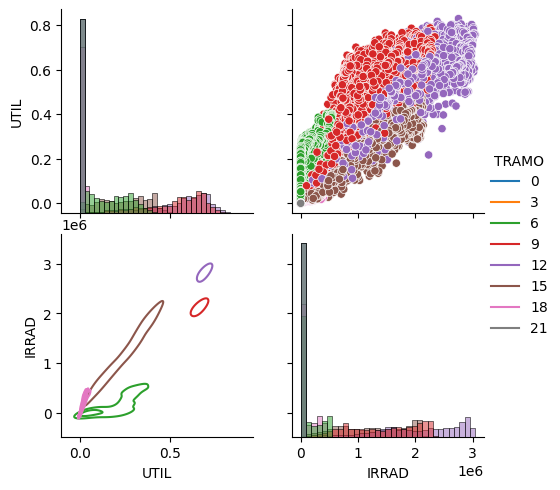

In [6]:
g = sns.PairGrid(df, hue="TRAMO")
g.map_diag(sns.histplot)
#g.map_offdiag(sns.scatterplot)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.add_legend()

Finally, in order to build the models, we split the data into training and testing sets. We will use the training set to train the model and the testing set to evaluate the model.

In [7]:
# Define input and output matrices
INPUTS = ['FECHA', 'IRRAD','ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']
OUTPUT = 'UTIL'
X = df[INPUTS]
y = df[OUTPUT]

# Normalmente en series temporales tendriamos que hacer una division secuencial
# sin embargo, como aqui tenemos variables que categorizan el dia, mes y año no es necesario
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,  #percentage of test data
                                                    random_state=0) #seed for replication

-------------- 
### MODEL 1 : SINGLE REGRESSION TREE

In [8]:
## Inputs of the model
INPUTS_DT = ['IRRAD','ANNO', 'DIA', 'DIASEM', 'MES', 'TRAMO']

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'RT__min_impurity_decrease': np.arange(0,0.05,0.005), # Minimum entropy to decrease in each split
         'RT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'RT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('RT', DecisionTreeRegressor(criterion='squared_error',  
                                                    random_state=150))])                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
tree_fit.fit(X_train[INPUTS_DT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'RT__min_impurity_decrease': array([0.   , 0.005, 0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 ,
       0.045]),
                         'RT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'RT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [9]:
# Show the best grid parameter combination found by CV
tree_fit.best_estimator_['RT'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 7,
 'min_samples_split': 1,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

##### Compute errors of the single regression tree

In [10]:
SRT_TR_X  = X_train
SRT_TST_X = X_test

In [11]:
##  Compute errors
DT_reg_estim= tree_fit.best_estimator_['RT']

print('Single Regression Tree')
y_train_est_DT =  DT_reg_estim.predict(X_train[INPUTS_DT])
y_test_est_DT =  DT_reg_estim.predict(X_test[INPUTS_DT])

SRT_TR_X['UTIL'] = y_train
SRT_TR_X['UTIL_PRED_DT'] = y_train_est_DT
SRT_TST_X['UTIL'] = y_test
SRT_TST_X['UTIL_PRED_DT'] = y_test_est_DT

mse_tr_DT = np.mean((y_train - y_train_est_DT)**2)
mse_ts_DT = np.mean((y_test - y_test_est_DT)**2)

mae_tr_DT = np.mean(np.abs(y_train - y_train_est_DT))
mae_ts_DT  = np.mean(np.abs(y_test - y_test_est_DT))

r2_squared_tr_DT = metrics.r2_score(y_train, y_train_est_DT)
r2_squared_ts_DT = metrics.r2_score(y_test, y_test_est_DT)

print(f'MSE(TR) = {mse_tr_DT}')
print(f'MSE(TS) = {mse_ts_DT}')

print(f'MAE(TR) = {mae_tr_DT}')
print(f'MAE(TS) = {mae_ts_DT}')

print(f"R-squared(TR): {r2_squared_tr_DT}")
print(f"R-squared(TS): {r2_squared_ts_DT}")


Single Regression Tree
MSE(TR) = 0.0007202704344823445
MSE(TS) = 0.0012530498590069424
MAE(TR) = 0.013230576847976454
MAE(TS) = 0.017689042213420048
R-squared(TR): 0.9878440008703913
R-squared(TS): 0.9791744031318315


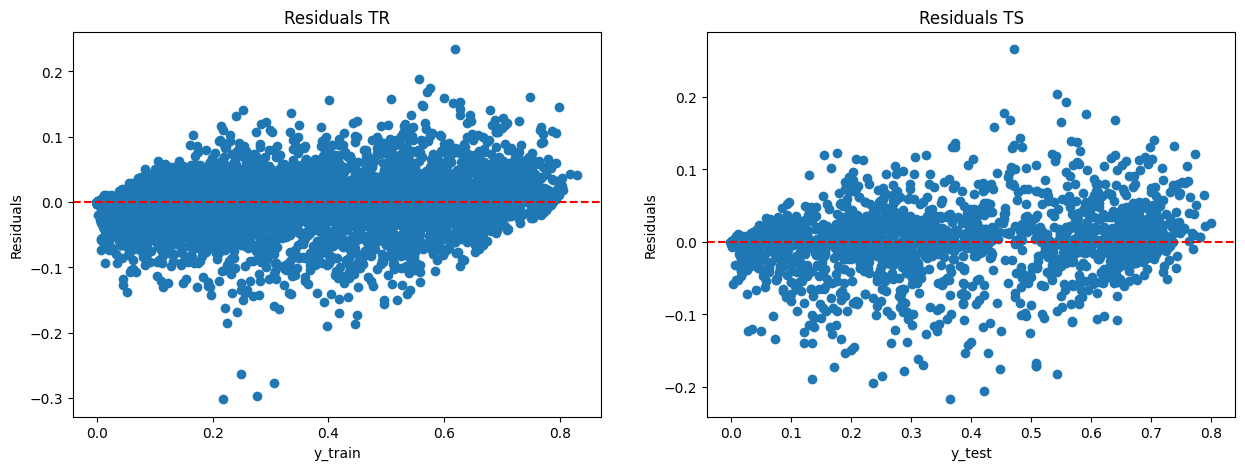

In [19]:
resid_tr = y_train - y_train_est_DT
resid_ts = y_test - y_test_est_DT

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y_train, resid_tr)
ax[0].axhline(y=0, color='red', linestyle='dashed')
ax[1].axhline(y=0, color='red', linestyle='dashed')
ax[0].set_title('Residuals TR')
ax[0].xaxis.set_label_text('y_train')
ax[0].yaxis.set_label_text('Residuals')
ax[1].scatter(y_test, resid_ts)
ax[1].set_title('Residuals TS')
ax[1].xaxis.set_label_text('y_test')
ax[1].yaxis.set_label_text('Residuals')
plt.show()

In [20]:
STR_TR_TEST = pd.concat([SRT_TR_X, SRT_TST_X]).sort_values('FECHA')

In [21]:
STR_TR_TEST

,FECHA,IRRAD,ANNO,DIA,DIASEM,MES,TRAMO,UTIL,UTIL_PRED_DT
0,2015-01-01 00:00:00,0.00,2015,1,3,1,0,0.000003,0.000003
1,2015-01-01 03:00:00,0.00,2015,1,3,1,3,0.000006,0.000005
2,2015-01-01 06:00:00,0.00,2015,1,3,1,6,0.067728,0.054784
3,2015-01-01 09:00:00,760335.40,2015,1,3,1,9,0.611120,0.596776
4,2015-01-01 12:00:00,1565422.50,2015,1,3,1,12,0.660956,0.639161
...,...,...,...,...,...,...,...,...,...
17531,2020-12-31 09:00:00,737550.70,2020,31,3,12,9,0.473071,0.451387
17532,2020-12-31 12:00:00,1398824.50,2020,31,3,12,12,0.474931,0.419596
17533,2020-12-31 15:00:00,675842.75,2020,31,3,12,15,0.108857,0.127879
17534,2020-12-31 18:00:00,0.00,2020,31,3,12,18,0.000004,0.000018


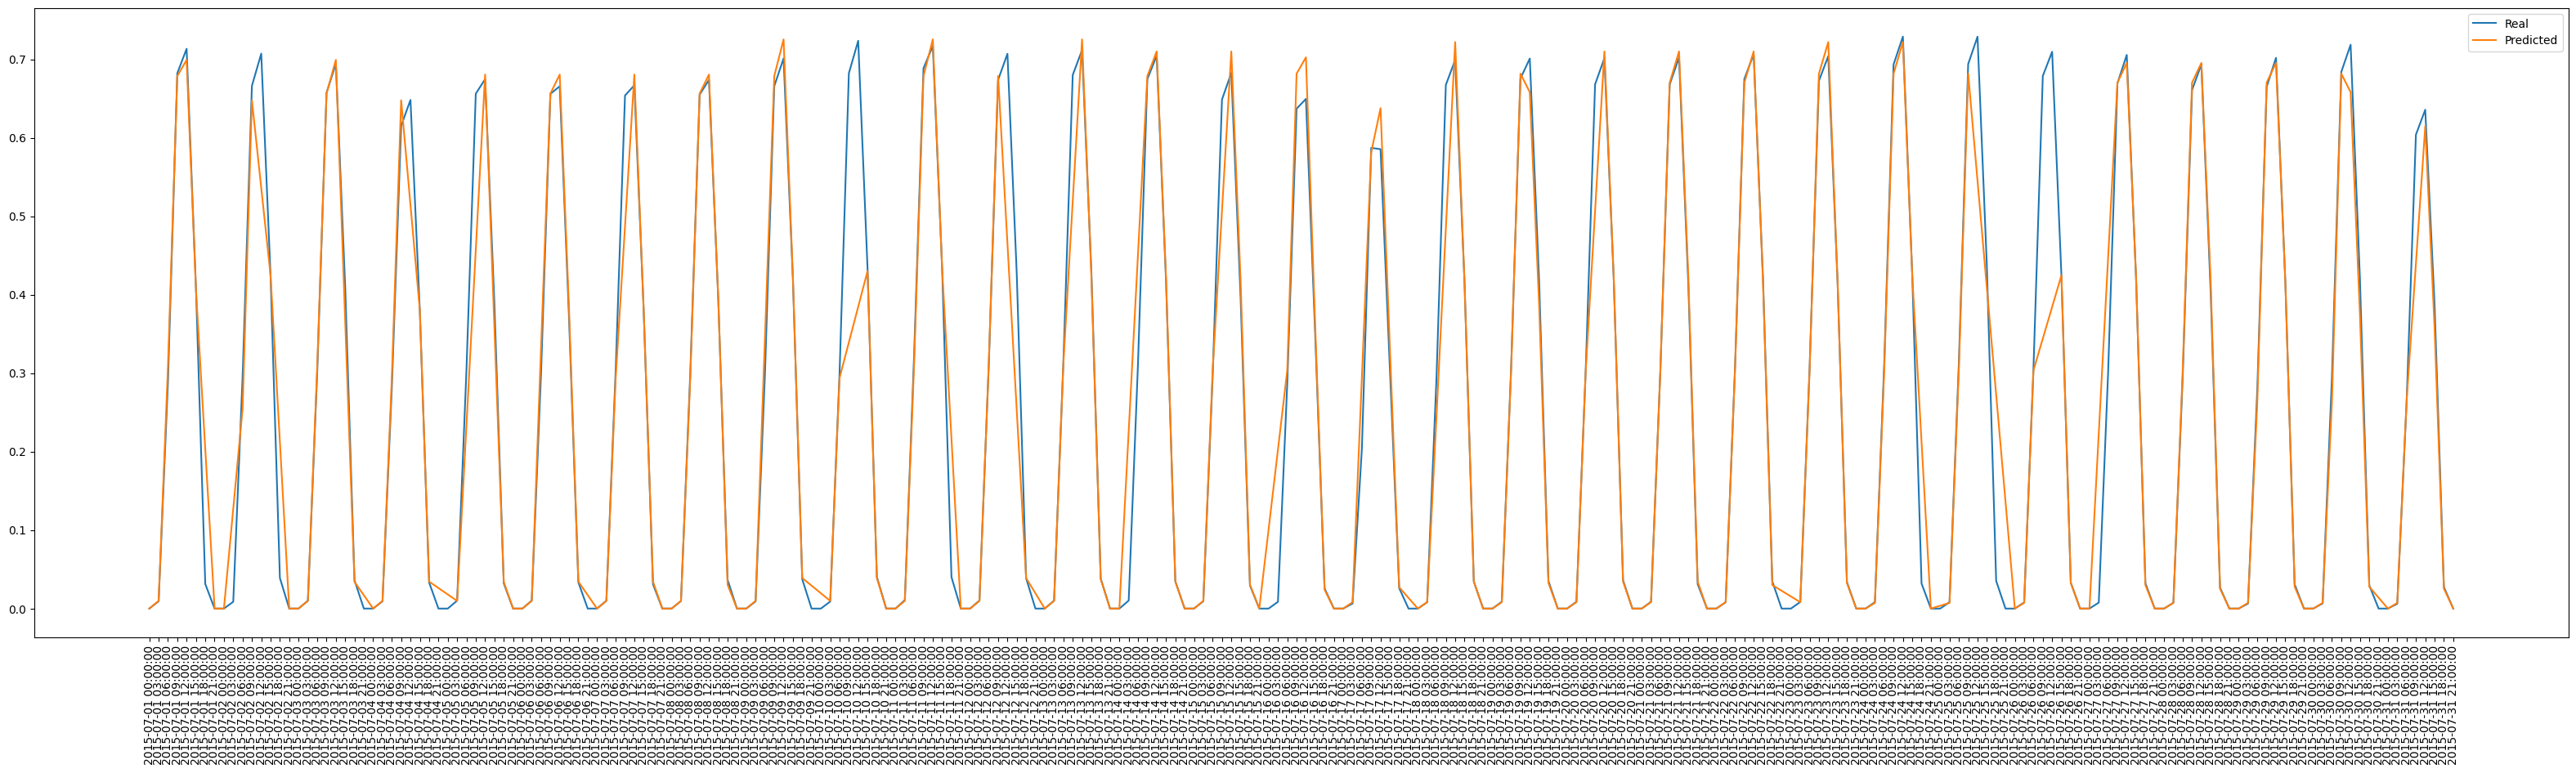

In [22]:
def plot_real_predicted(year, month):
    real = STR_TR_TEST[(STR_TR_TEST['ANNO'] == year) & (STR_TR_TEST['MES'] == month) ]
    predicted = STR_TR_TEST[(SRT_TR_X['ANNO'] == year) & (STR_TR_TEST['MES'] == month) ]
    
    plt.figure(figsize=(40, 10))
    plt.plot(real['FECHA'], real['UTIL'], label='Real')
    plt.plot(predicted['FECHA'], predicted['UTIL_PRED_DT'], label='Predicted')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
    
plot_real_predicted(2015, 7)

##### Feature Importances of the inputs in the single tree

Here we would expect the irradiation and the hour time-period to be the most important features in the model from the EDA done in the previous notebook.

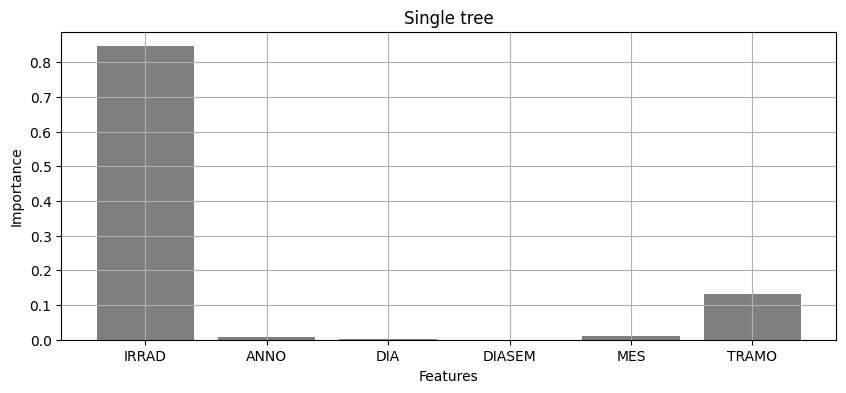

In [23]:
## Plot the variable importance of each feature
plt.figure(figsize=(10, 4))
bar_width = 0.35
plt.bar(INPUTS_DT, tree_fit.best_estimator_['RT'].feature_importances_, color='black', alpha=0.5)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Single tree')
plt.grid()
plt.show()

-----------------
### MODEL 2: BAGGED TREE

##### First straightforward version (without optim hyperparameters)

In [24]:
number_estimators = 50
base_estimator =  Pipeline(steps=[('RT', 
                                    DecisionTreeRegressor( criterion='squared_error',  # impurity measure
                                                            random_state=999))]) # For replication


bag_reg_estim = BaggingRegressor(estimator=base_estimator,
                                    n_estimators=number_estimators,
                                    random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS_DT                 
bag_reg_estim.fit(X_train[INPUTS_BT], y_train)

BaggingRegressor(estimator=Pipeline(steps=[('RT',
                                            DecisionTreeRegressor(random_state=999))]),
                 n_estimators=50, random_state=0)

In [25]:
# Show the best grid parameter combination found by CV
bag_reg_estim.get_params()

{'base_estimator': 'deprecated',
 'bootstrap': True,
 'bootstrap_features': False,
 'estimator__memory': None,
 'estimator__steps': [('RT', DecisionTreeRegressor(random_state=999))],
 'estimator__verbose': False,
 'estimator__RT': DecisionTreeRegressor(random_state=999),
 'estimator__RT__ccp_alpha': 0.0,
 'estimator__RT__criterion': 'squared_error',
 'estimator__RT__max_depth': None,
 'estimator__RT__max_features': None,
 'estimator__RT__max_leaf_nodes': None,
 'estimator__RT__min_impurity_decrease': 0.0,
 'estimator__RT__min_samples_leaf': 1,
 'estimator__RT__min_samples_split': 2,
 'estimator__RT__min_weight_fraction_leaf': 0.0,
 'estimator__RT__random_state': 999,
 'estimator__RT__splitter': 'best',
 'estimator': Pipeline(steps=[('RT', DecisionTreeRegressor(random_state=999))]),
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

##### Compute errors of the bagged tree

In [27]:
##  Compute errors
BT_bag_reg_estim= bag_reg_estim

print('Single Regression Tree')
y_train_est_BT =  BT_bag_reg_estim.predict(X_train[INPUTS_BT])
y_test_est_BT =  BT_bag_reg_estim.predict(X_test[INPUTS_BT])

SRT_TR_X['UTIL_PRED_BT'] = y_train_est_BT
SRT_TST_X['UTIL_PRED_BT'] = y_test_est_BT

mse_tr_BT = np.mean((y_train - y_train_est_BT)**2)
mse_ts_BT = np.mean((y_test - y_test_est_BT)**2)

mae_tr_BT = np.mean(np.abs(y_train - y_train_est_BT))
mae_ts_BT  = np.mean(np.abs(y_test - y_test_est_BT))

r2_squared_tr_BT = metrics.r2_score(y_train, y_train_est_BT)
r2_squared_ts_BT = metrics.r2_score(y_test, y_test_est_BT)

print(f'MSE(TR) = {mse_tr_BT}')
print(f'MSE(TS) = {mse_ts_BT}')

print(f'MAE(TR) = {mae_tr_BT}')
print(f'MAE(TS) = {mae_ts_BT}')

print(f"R-squared(TR): {r2_squared_tr_BT}")
print(f"R-squared(TS): {r2_squared_ts_BT}")

Single Regression Tree
MSE(TR) = 0.00014917768267676412
MSE(TS) = 0.0009989468597614464
MAE(TR) = 0.00593292393814351
MAE(TS) = 0.01570294000772258
R-squared(TR): 0.9974823292836127
R-squared(TS): 0.9833975763657147


In [30]:
PRED = pd.concat( [SRT_TR_X, SRT_TST_X] ).sort_values('FECHA')

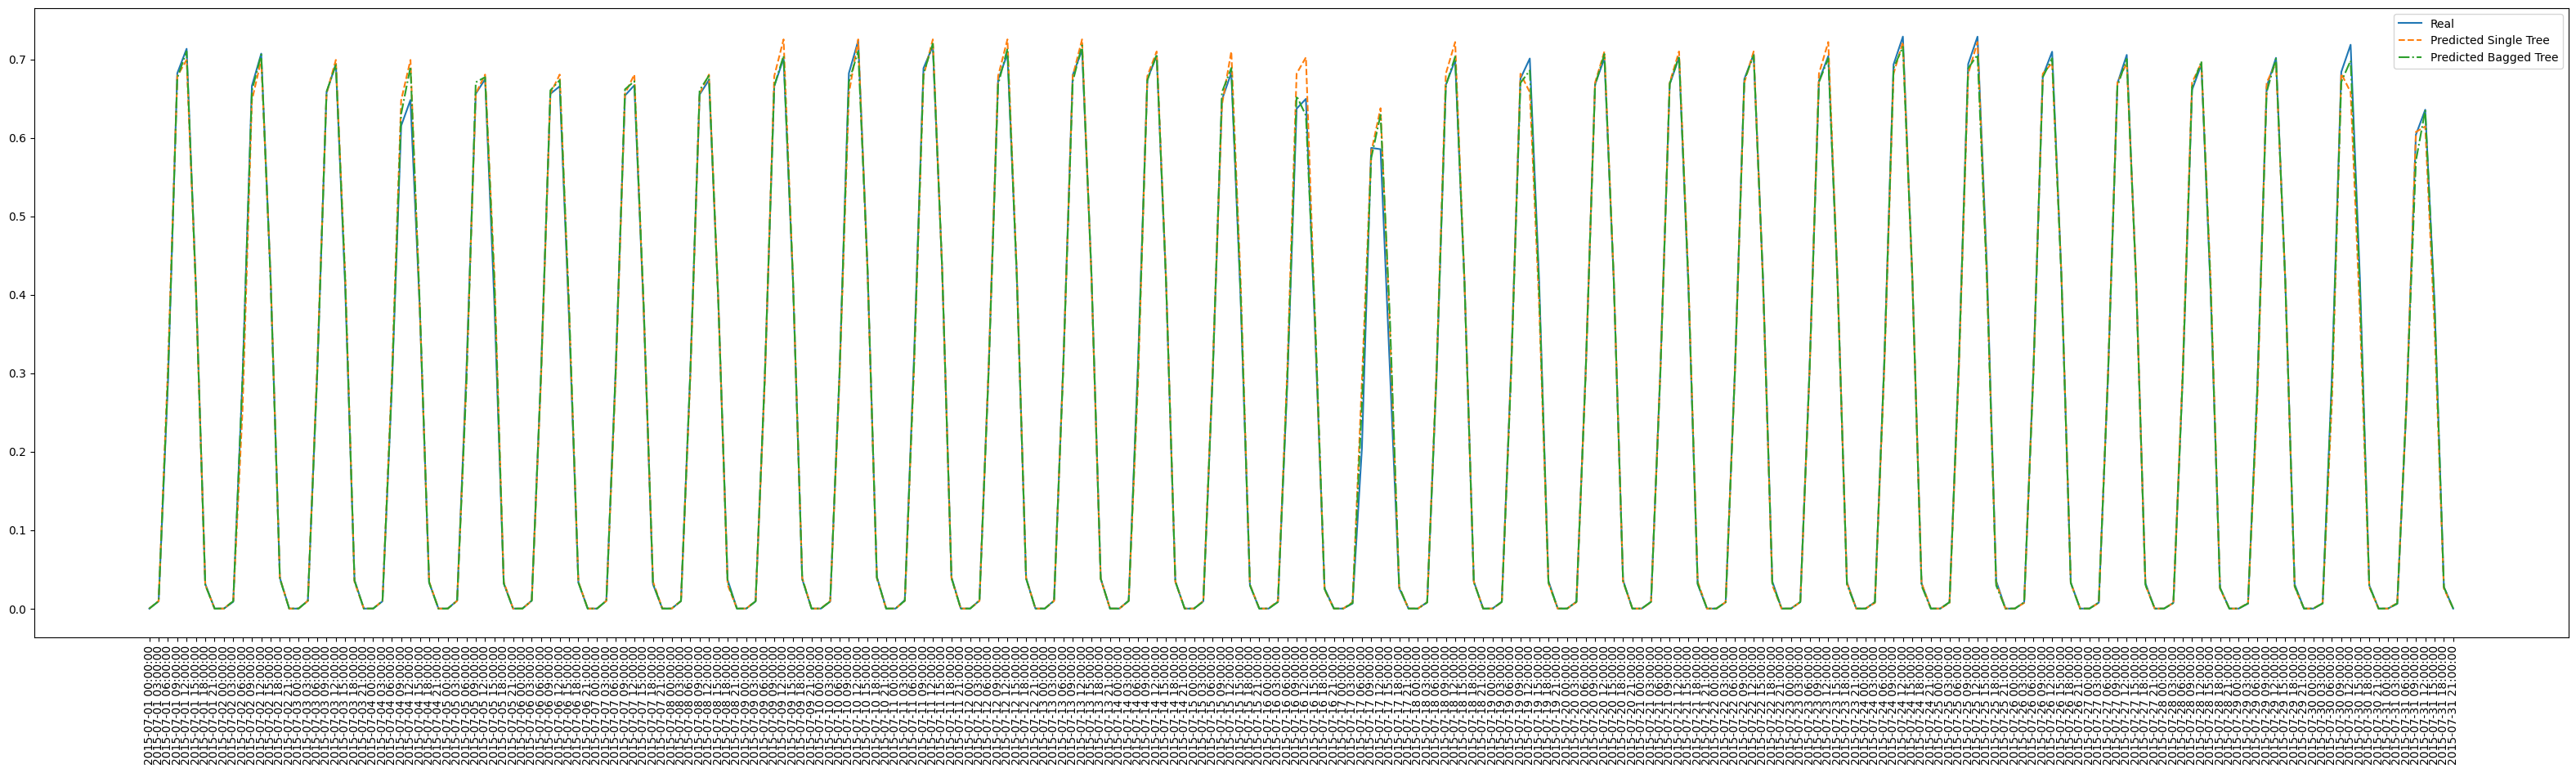

In [31]:
def plot_real_predicted(year, month):
    real = PRED[(PRED['ANNO'] == year) & (PRED['MES'] == month) ]
    predicted = PRED[(PRED['ANNO'] == year) & (PRED['MES'] == month) ]
    
    plt.figure(figsize=(40, 10))
    plt.plot(real['FECHA'], real['UTIL'], label='Real')
    plt.plot(predicted['FECHA'], predicted['UTIL_PRED_DT'], label='Predicted Single Tree', linestyle='--')
    plt.plot(predicted['FECHA'], predicted['UTIL_PRED_BT'], label='Predicted Bagged Tree', linestyle='-.')
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()
    
plot_real_predicted(2015, 7)

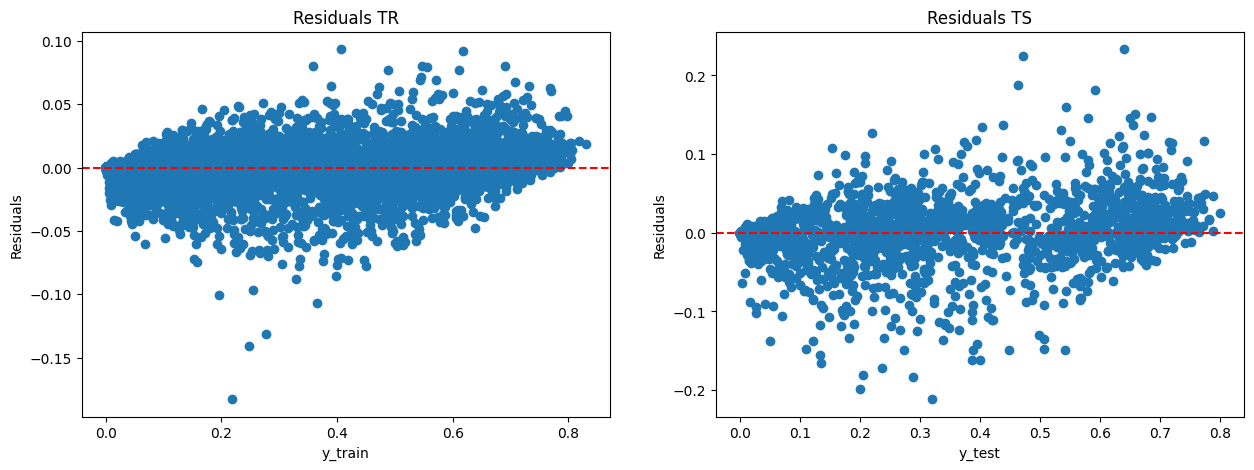

In [32]:
resid_tr_bt = y_train - y_train_est_BT
resid_ts_bt = y_test - y_test_est_BT

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(y_train, resid_tr_bt)
ax[0].axhline(y=0, color='red', linestyle='dashed')
ax[1].axhline(y=0, color='red', linestyle='dashed')
ax[0].set_title('Residuals TR')
ax[0].xaxis.set_label_text('y_train')
ax[0].yaxis.set_label_text('Residuals')
ax[1].scatter(y_test, resid_ts_bt)
ax[1].set_title('Residuals TS')
ax[1].xaxis.set_label_text('y_test')
ax[1].yaxis.set_label_text('Residuals')
plt.show()

#####  Feature importance evaluation in bagging using "Permutation Importance"

The permutation importance of a feature is calculated as follows:
- First, a baseline metric, defined by scoring, is evaluated on a (potentially different) dataset defined by the X. 
- Next, a feature column from the validation set is permuted and the metric is evaluated again. 
- The permutation importance is defined to be the difference between the baseline metric and metric from permutating the feature column.

For further reading see L. Breiman, “Random Forests”, Machine Learning, 45(1), 5-32, 2001.

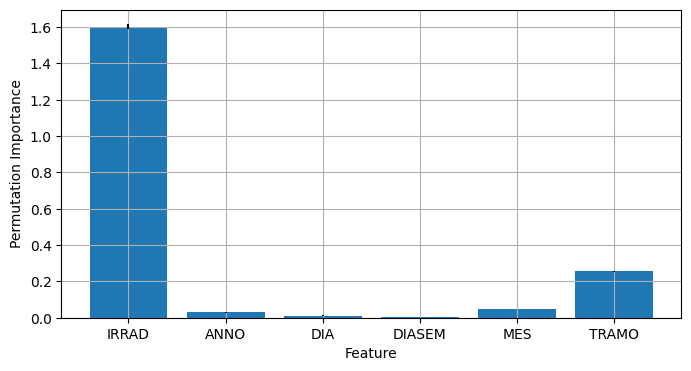

In [33]:
importances_reg_class_estim = permutation_importance(bag_reg_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10,
                                    random_state=0)

fig = plt.figure(2, figsize=(8, 4)) 
plt.bar(INPUTS_DT, importances_reg_class_estim.importances_mean, yerr=importances_reg_class_estim.importances_std)
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.grid()
plt.show()

#### Plot some trees of the ensemble

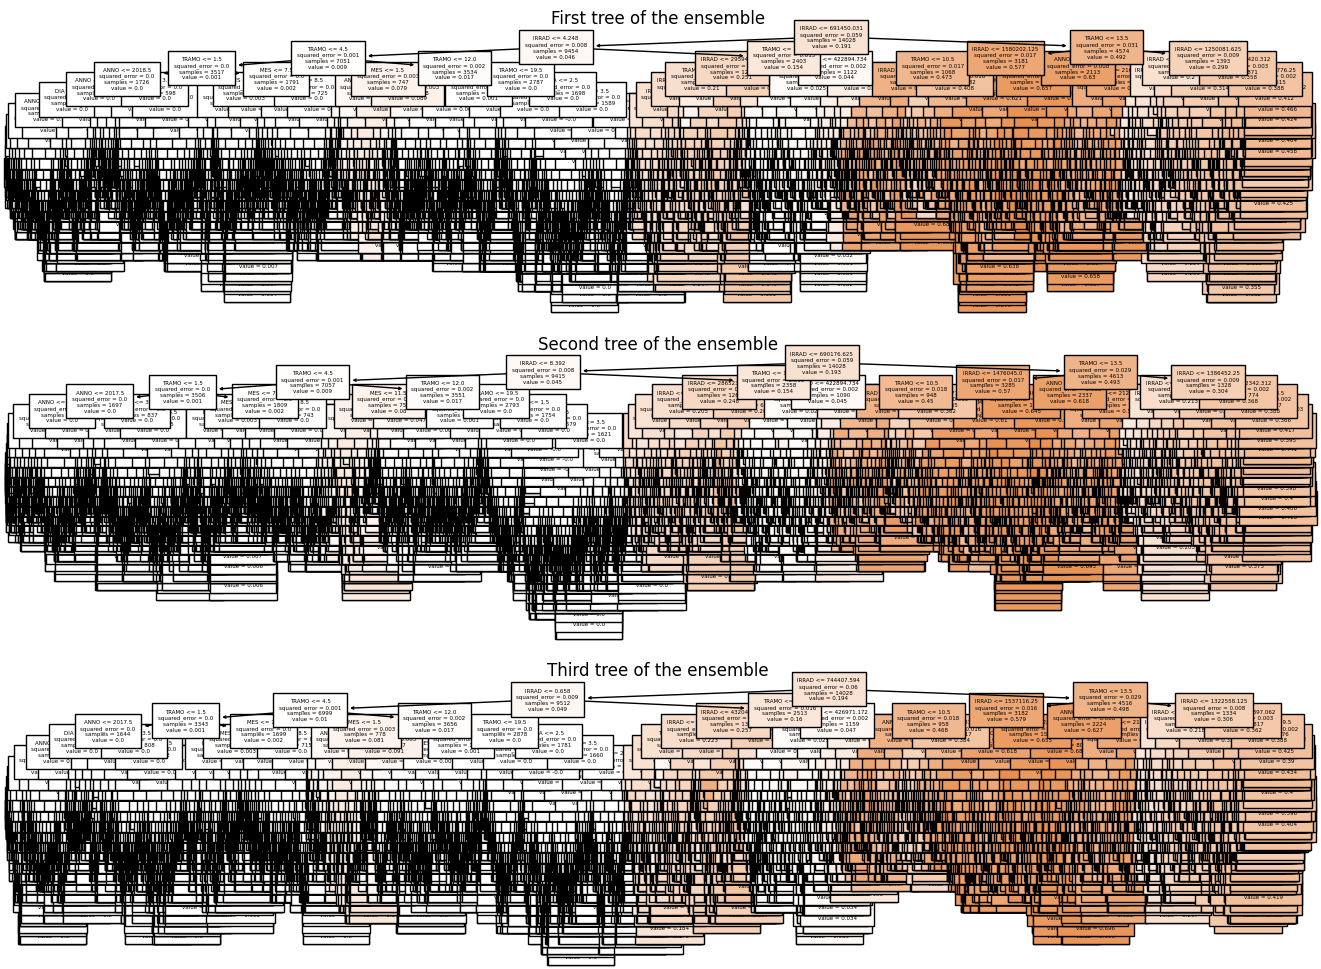

In [27]:
## Plot first trees of the ensemble
plt.figure(figsize=(16, 12))
plt.subplot(3,1,1)
plot_tree(bag_reg_estim.estimators_[0]['RT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'First tree of the ensemble')
plt.subplot(3,1,2)
plot_tree(bag_reg_estim.estimators_[1]['RT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Second tree of the ensemble')
plt.subplot(3,1,3)
plot_tree(bag_reg_estim.estimators_[2]['RT'], feature_names= INPUTS_BT, fontsize=4, filled=True)
plt.title(f'Third tree of the ensemble')
plt.show()

#### Variability in the ensemble

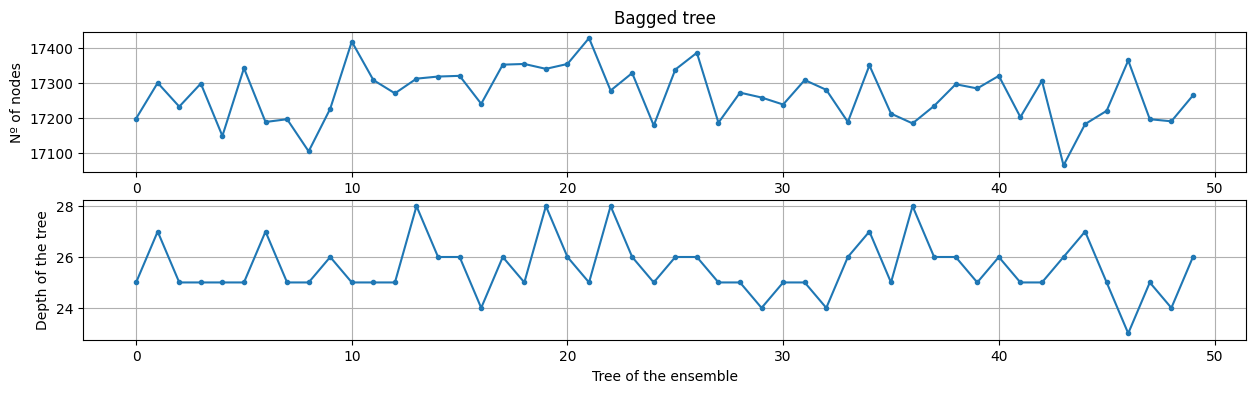

In [34]:
# number of nodes in each tree of the ensemble
node_count_trees_bt = [t['RT'].tree_.node_count for t in bag_reg_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees_bt = [t['RT'].tree_.max_depth for t in bag_reg_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees_bt, '.-')
plt.ylabel('Nº of nodes')
plt.title('Bagged tree')                  
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees_bt, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

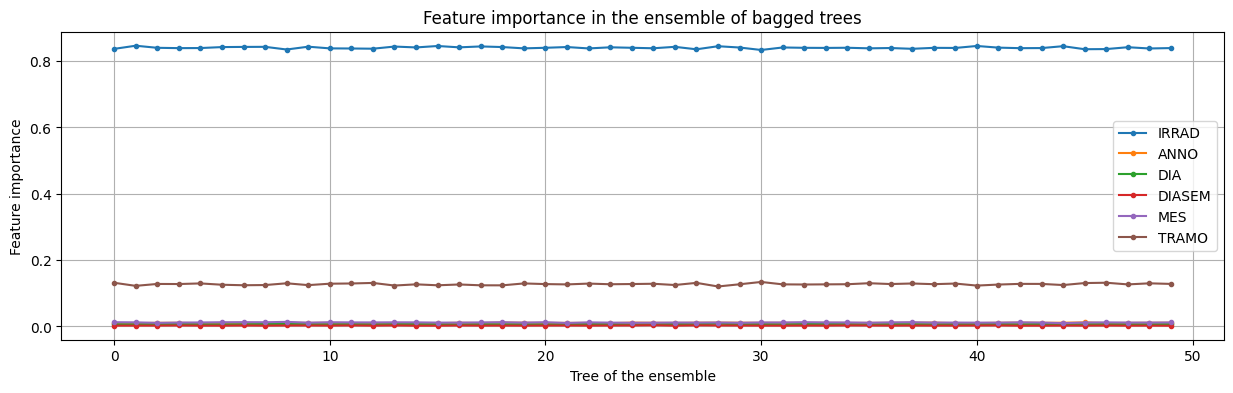

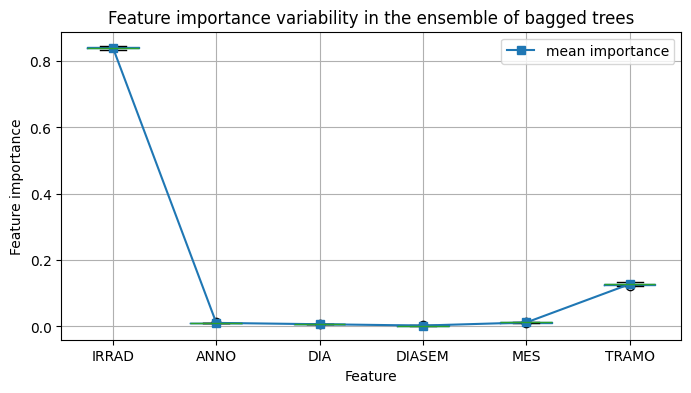

In [35]:
# feature importances of each tree in the ensemble
feature_importances_trees = [t['RT'].feature_importances_ for t in bag_reg_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
plt.plot(feature_importances_trees, '.-', label = INPUTS_BT)
plt.ylabel('Feature importance') 
plt.xlabel('Tree of the ensemble')                                 
plt.title('Feature importance in the ensemble of bagged trees')
plt.grid()
plt.legend()
plt.show()

# global view of feature importances
dfimp =  pd.DataFrame(list(feature_importances_trees), columns=INPUTS_BT)
dfimp.boxplot(figsize=(8, 4))
plt.plot(np.arange(len(INPUTS_BT))+1, dfimp.mean(),'s-', label ='mean importance')
plt.ylabel('Feature importance') 
plt.xlabel('Feature') 
plt.title('Feature importance variability in the ensemble of bagged trees')
plt.legend()
plt.show()

####  Vote of each tree of the ensemble for each observation in the set

In [32]:
clf = bag_reg_estim
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
y_train_pred_trees = list([t['RT'].predict(X_train[INPUTS_DT]) for t in bag_reg_estim.estimators_])

dfouts = pd.DataFrame(y_train_pred_trees)
dfouts.head()

y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()
y_test_pred_trees = list([t['RT'].predict(X_test[INPUTS_DT]) for t in bag_reg_estim.estimators_])

dfouts_tr = pd.DataFrame(y_train_pred_trees)
dfouts_tr.head()
dfouts_ts = pd.DataFrame(y_test_pred_trees)
dfouts_ts.head()

c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
c:\Users\isaan\anaconda3\envs\ML2\lib\site-packages\sklearn\base.py:402: UserWarning:

,0,1,2,3,4,5,6,7,8,9,...,3498,3499,3500,3501,3502,3503,3504,3505,3506,3507
0,0.034328,0.000025,0.000010,0.211037,0.593726,0.667310,0.751455,0.046022,0.000031,0.010189,...,0.560307,0.000008,0.000075,0.030120,0.029485,0.005533,0.000653,0.000248,0.175372,0.658716
1,0.037412,0.000012,0.000004,0.316175,0.644321,0.697222,0.662034,0.028127,0.000031,0.010189,...,0.578556,0.000012,0.000085,0.023258,0.033176,0.007519,0.000748,0.000252,0.169077,0.630015
2,0.033752,0.000015,0.000010,0.313906,0.622385,0.697222,0.743098,0.077813,0.000031,0.010189,...,0.503113,0.000081,0.000081,0.036626,0.033066,0.007293,0.000748,0.000252,0.117583,0.630015
3,0.034392,0.000009,0.000004,0.304111,0.647064,0.640207,0.613654,0.023379,0.000031,0.010189,...,0.499721,0.000081,0.000065,0.028529,0.031579,0.006949,0.000748,0.000202,0.117583,0.635713
4,0.036035,0.000011,0.000002,0.313906,0.653277,0.667310,0.743098,0.058023,0.000010,0.009165,...,0.578556,0.000063,0.000075,0.028529,0.026007,0.005226,0.000748,0.000252,0.252139,0.626584


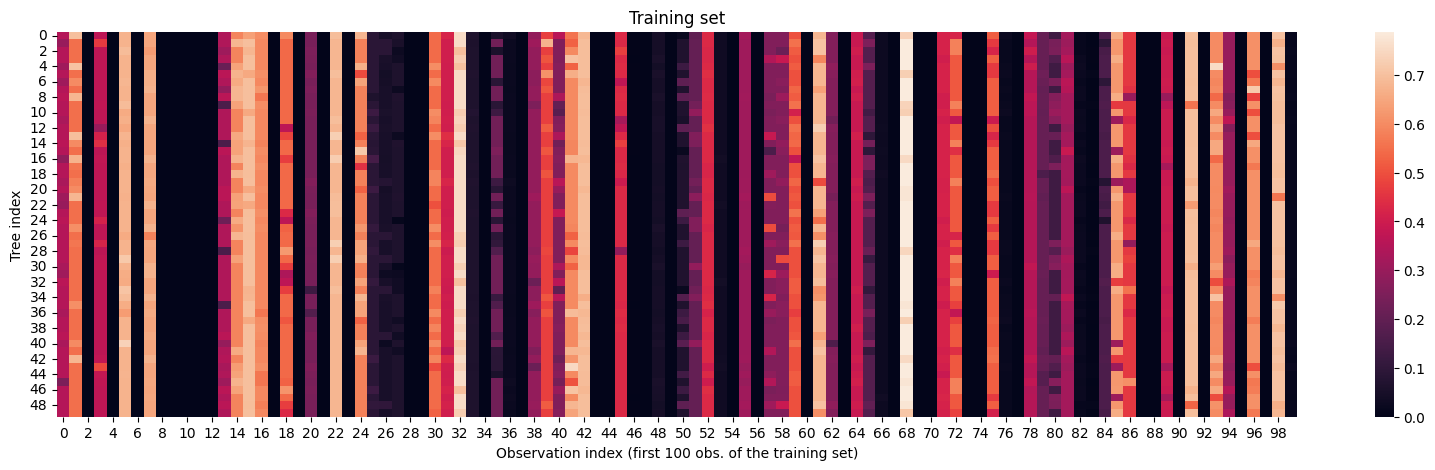

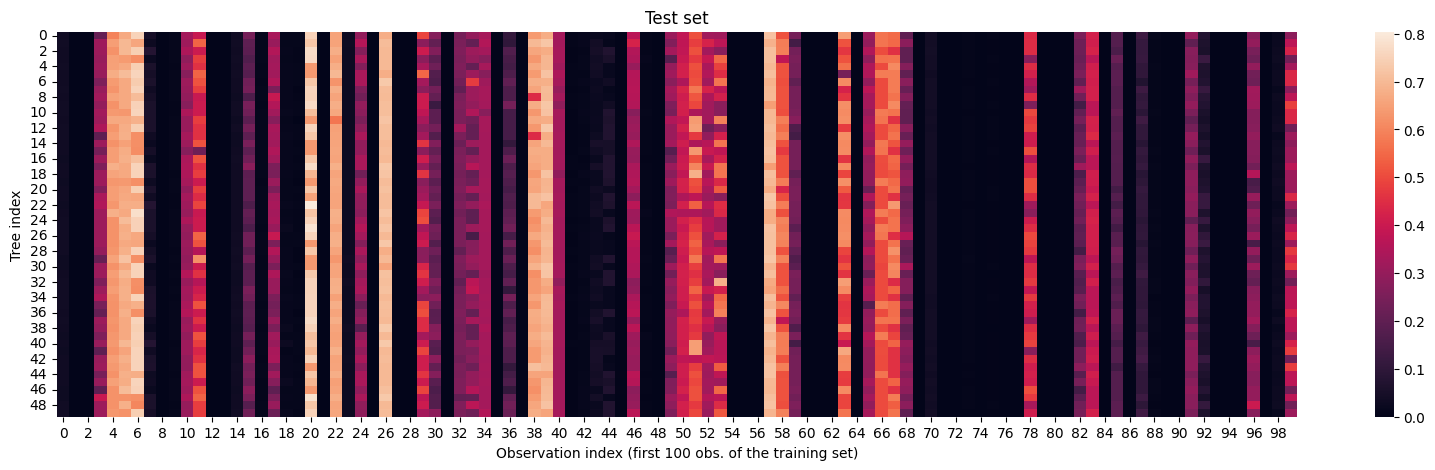

In [33]:
# plot the votes of each tree for the first 100 observations of the training set
fig = plt.figure(figsize=(20, 5))
sns.heatmap(dfouts_tr.iloc[:,:100])
plt.xlabel('Observation index (first 100 obs. of the training set)')
plt.ylabel('Tree index')
plt.title('Training set')                                 
plt.show()

fig = plt.figure(figsize=(20, 5))
sns.heatmap(dfouts_ts.iloc[:,:100])
plt.xlabel('Observation index (first 100 obs. of the training set)')
plt.ylabel('Tree index')
plt.title('Test set')                                 
plt.show()

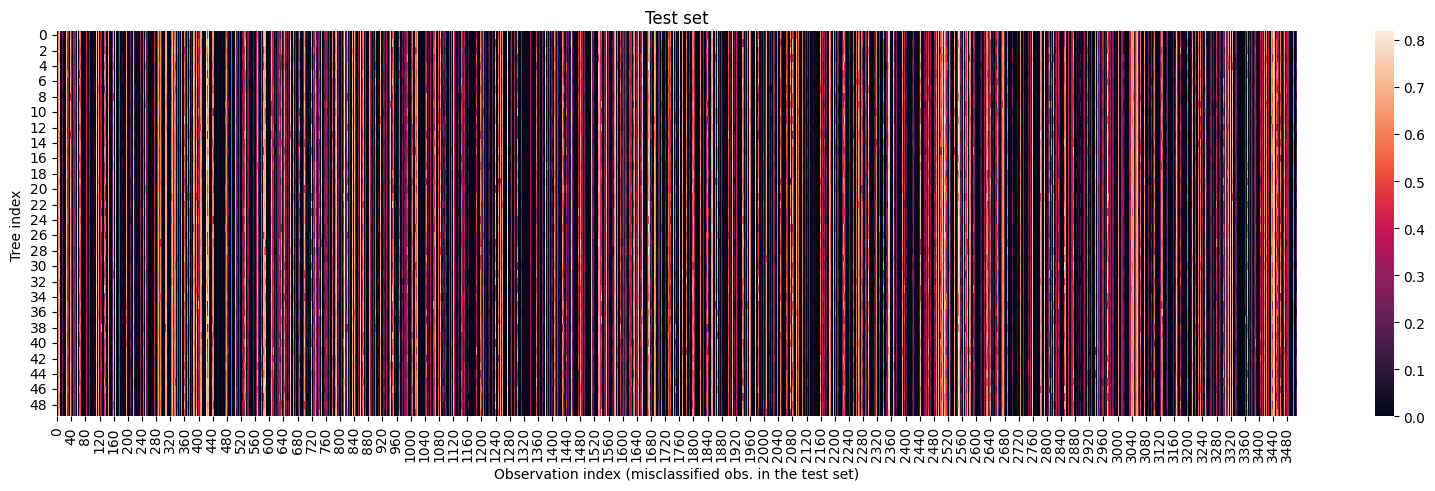

In [34]:
# focus on the misclassified observations
y_train_pred = clf.predict(X_train[INPUTS_DT]).tolist()
class_errors_tr = [x!=y for x,y in zip(y_train.tolist(), y_train_pred)]

y_test_pred = clf.predict(X_test[INPUTS_DT]).tolist()
class_errors_ts = [x!=y for x,y in zip(y_test.tolist(), y_test_pred)]

# plot the votes of each tree for the first 100 observations of the training set
fig = plt.figure(1,figsize=(20, 5))
sns.heatmap(dfouts_ts.iloc[:,class_errors_ts])
plt.xlabel('Observation index (misclassified obs. in the test set)')
plt.ylabel('Tree index')
plt.title('Test set')                                 
plt.show()

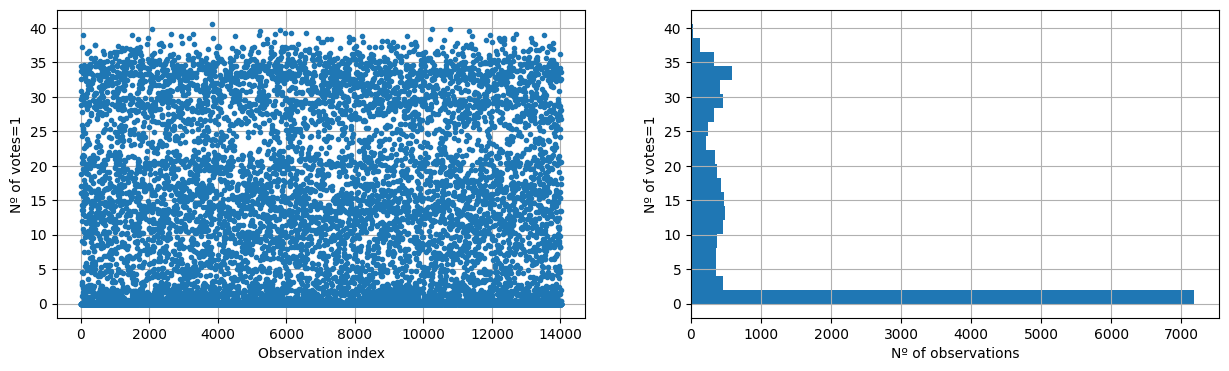

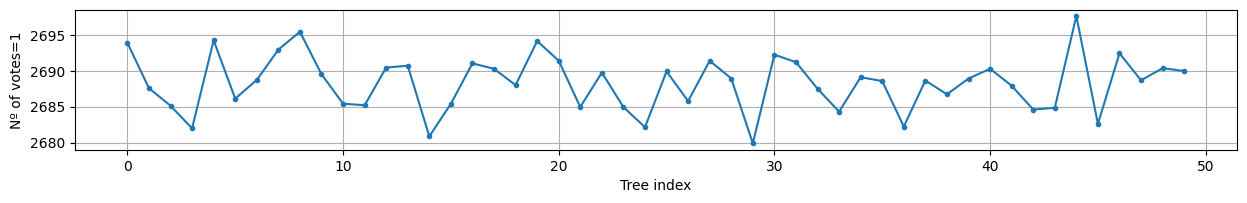

In [35]:
#number of votes = 1 for each observation
n_1s_each_obs = dfouts.sum(axis=0)

# number of ones for each tree
n_1s_each_tree = dfouts.sum(axis=1)

# plot
fig = plt.figure(figsize=(15, 4))
ax1=plt.subplot(1,2,1)
plt.plot(n_1s_each_obs, '.')
plt.ylabel('Nº of votes=1')
plt.xlabel('Observation index')                       
plt.grid()

plt.subplot(1,2,2,sharey=ax1)
plt.hist(n_1s_each_obs,bins=20,orientation='horizontal')
plt.ylabel('Nº of votes=1')
plt.xlabel('Nº of observations')
plt.grid()
plt.show()

fig = plt.figure(figsize=(15, 4))
plt.subplot(2,1,2)
plt.plot(n_1s_each_tree, '.-')
plt.ylabel('Nº of votes=1')                       
plt.xlabel('Tree index')                  
plt.grid()
plt.show()

------------- 
### MODEL 2.1: BAGGED TREE WITH OPTIMAL PARAMETERS

In [38]:
# find optim nº of trees in the ensemble
param = {'BT__n_estimators': range(20, 150, 5)} # Number of trees to aggregate

pipe =  Pipeline(steps=[('BT', 
                            BaggingRegressor(estimator=base_estimator,
                                              random_state=150))])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
bt_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
bt_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('BT',
                                        BaggingRegressor(estimator=Pipeline(steps=[('RT',
                                                                                    DecisionTreeRegressor(random_state=999))]),
                                                         random_state=150))]),
             n_jobs=-1, param_grid={'BT__n_estimators': range(20, 150, 5)})

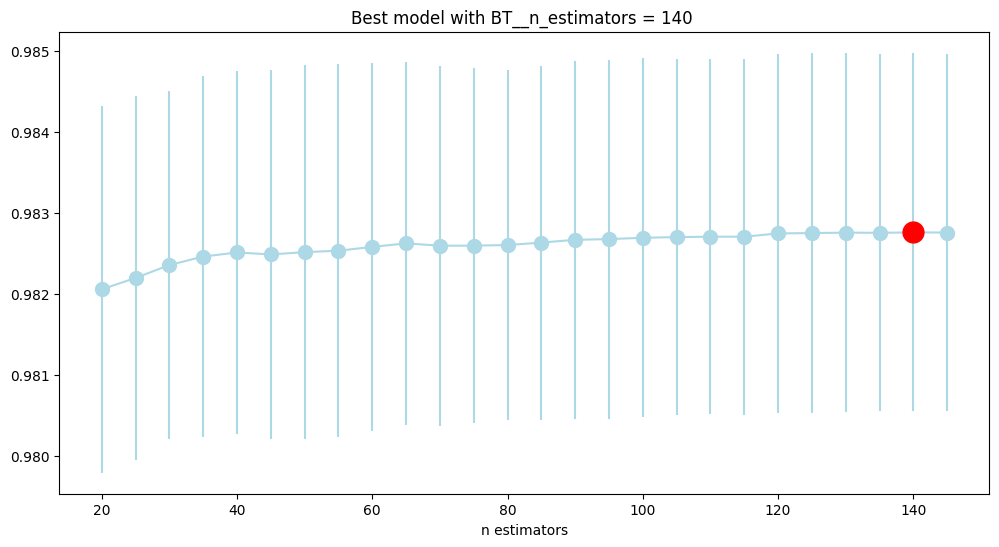

In [39]:
MT.plotModelGridError(bt_fit)

In [42]:
# Show the best grid parameter combination found by CV
bt_fit.best_estimator_['BT'].get_params()
##### Compute errors of the single regression tree
##  Compute errors
BT_reg_estim= bt_fit.best_estimator_['BT']

print('Bagged Tree')
y_train_est_BT2 =  BT_reg_estim.predict(X_train)
y_test_est_BT2 =  BT_reg_estim.predict(X_test)

mse_tr_BT2 = np.mean((y_train - y_train_est_BT2)**2)
mse_ts_BT2 = np.mean((y_test - y_test_est_BT2)**2)

mae_tr_BT2 = np.mean(np.abs(y_train - y_train_est_BT2))
mae_ts_BT2  = np.mean(np.abs(y_test - y_test_est_BT2))

r2_squared_tr_BT2 = metrics.r2_score(y_train, y_train_est_BT2)
r2_squared_ts_BT2 = metrics.r2_score(y_test, y_test_est_BT2)

print(f'MSE(TR) = {mse_tr_BT2}')
print(f'MSE(TS) = {mse_ts_BT2}')

print(f'MAE(TR) = {mae_tr_BT2}')
print(f'MAE(TS) = {mae_ts_BT2}')

print(f"R-squared(TR): {r2_squared_tr_BT2}")
print(f"R-squared(TS): {r2_squared_ts_BT2}")


Bagged Tree
MSE(TR) = 0.00013833608438444884
MSE(TS) = 0.0009874912961494035
MAE(TR) = 0.005757843107546516
MAE(TS) = 0.015573876823497182
R-squared(TR): 0.9976653028628346
R-squared(TS): 0.9835879669938028


--------------- 
### MODEL 3: RANDOM FOREST

In [43]:

number_estimators = 50

# The number of features to consider when looking for the best split:
m = 'sqrt' # max_features{“sqrt”, “log2”, None}, int or float, default=”sqrt”

RF_class_estim = RandomForestRegressor(n_estimators=number_estimators,
                                        max_features=m,
                                        criterion='squared_error',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                     
# fit the bagged trees
INPUTS_BT = INPUTS                 
RF_class_estim.fit(X_train[INPUTS_BT], y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=50, random_state=0)

#### Importances of the inputs in the random forest

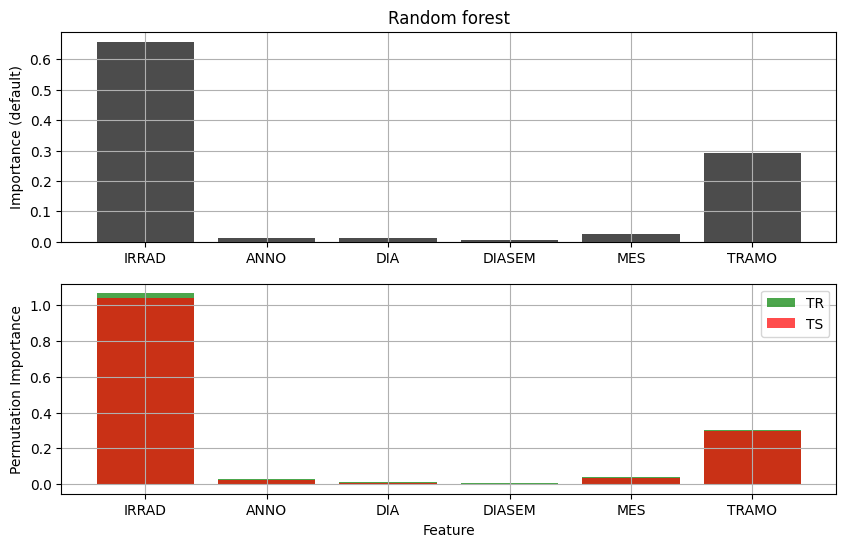

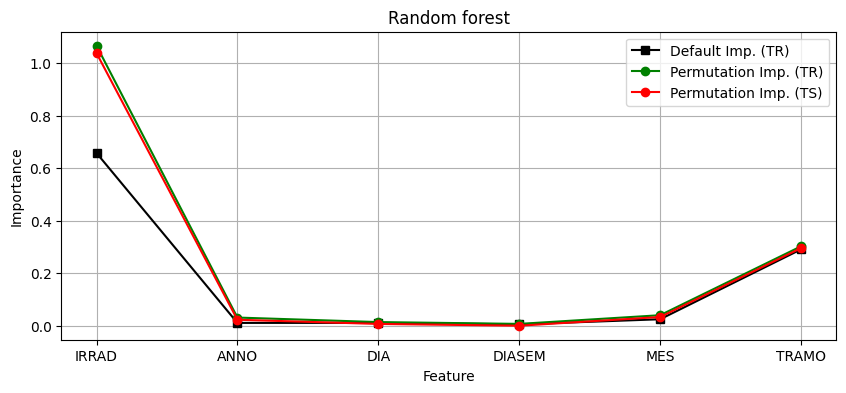

In [44]:
## Feature importance evaluation using "Permutation Importance" (training and test)
importances_tr_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_train[INPUTS_DT], y_train,
                                    n_repeats=10,
                                    random_state=0)

importances_ts_RF_class_estim = permutation_importance(RF_class_estim, 
                                    X_test[INPUTS_DT], y_test,
                                    n_repeats=10,
                                    random_state=0)
 
## Plot importances

# Plot the variable importance of each feature given by feature_importances_ attribute
plt.figure(figsize=(10, 6))

plt.subplot(2,1,1)
plt.bar(INPUTS_DT, RF_class_estim.feature_importances_, color='black', alpha=0.7)
plt.ylabel('Importance (default)')
plt.title('Random forest')
plt.grid()

plt.subplot(2,1,2)
plt.bar(INPUTS_DT, importances_tr_RF_class_estim.importances_mean, color='green', alpha=0.7, label='TR')
plt.bar(INPUTS_DT, importances_ts_RF_class_estim.importances_mean, color='red', alpha=0.7, label='TS')
plt.xlabel('Feature')
plt.ylabel('Permutation Importance')
plt.legend()
plt.grid()
plt.show()

# Plot the variable importances of each feature (all together)
plt.figure(figsize=(10, 4))

plt.plot(INPUTS_DT, RF_class_estim.feature_importances_, 's-',  color='black', label='Default Imp. (TR)')
plt.plot(INPUTS_DT, importances_tr_RF_class_estim.importances_mean, 'o-', color='green', label='Permutation Imp. (TR)')
plt.plot(INPUTS_DT, importances_ts_RF_class_estim.importances_mean, 'o-', color='red', label='Permutation Imp. (TS)')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Random forest')
plt.legend()
plt.grid()
plt.show()

#### Compute errors of the forest

In [45]:
##  Compute errors
RF_reg_estim= RF_class_estim

In [46]:
print('Random Forest')
y_train_est_RF =  RF_reg_estim.predict(X_train)
y_test_est_RF =  RF_reg_estim.predict(X_test)

mse_tr_RF = np.mean((y_train - y_train_est_RF)**2)
mse_ts_RF = np.mean((y_test - y_test_est_RF)**2)

mae_tr_RF = np.mean(np.abs(y_train - y_train_est_RF))
mae_ts_RF  = np.mean(np.abs(y_test - y_test_est_RF))

print(f'MSE(TR) = {mse_tr_RF}')
print(f'MSE(TS) = {mse_ts_RF}')

print(f'MAE(TR) = {mae_tr_RF}')
print(f'MAE(TS) = {mae_ts_RF}')

r2_squared_tr_RF = metrics.r2_score(y_train, y_train_est_RF)
r2_squared_ts_RF = metrics.r2_score(y_test, y_test_est_RF)

print(f"R-squared(TR): {r2_squared_tr_RF}")
print(f"R-squared(TS): {r2_squared_ts_RF}")

Random Forest
MSE(TR) = 0.00018069363240927436
MSE(TS) = 0.0011883064288121992
MAE(TR) = 0.006882840408600483
MAE(TS) = 0.018140992324656234
R-squared(TR): 0.9969504348184559
R-squared(TS): 0.9802504341990762


#### Variability in the forest

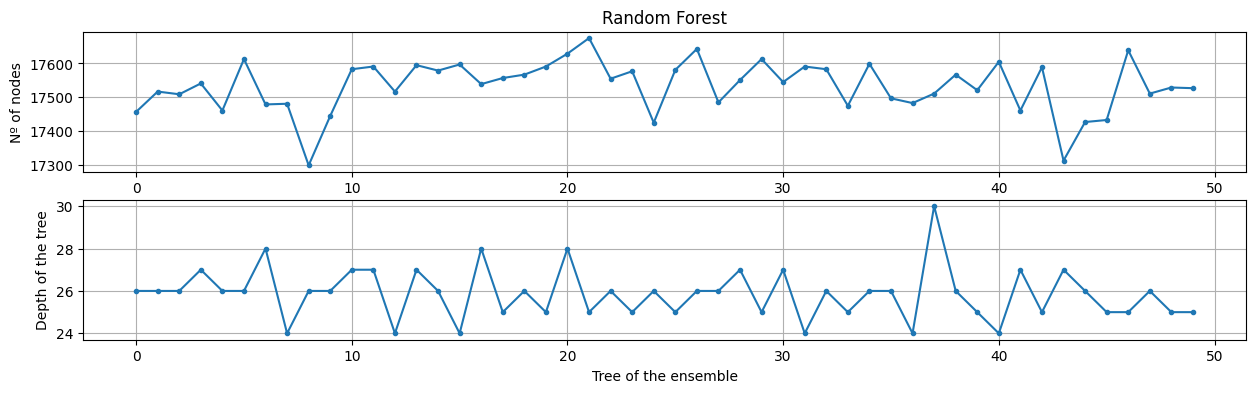

In [47]:
# number of nodes in each tree of the forest
node_count_trees_rf = [t.tree_.node_count for t in RF_class_estim.estimators_]

# number of nodes in each tree of the ensemble
depth_trees_rf = [t.tree_.max_depth for t in RF_class_estim.estimators_]

fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees_rf, '.-')
plt.ylabel('Nº of nodes')     
plt.title('Random Forest')                  
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees_rf, '.-')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.show()

Bagged tree vs Random Forest variablity

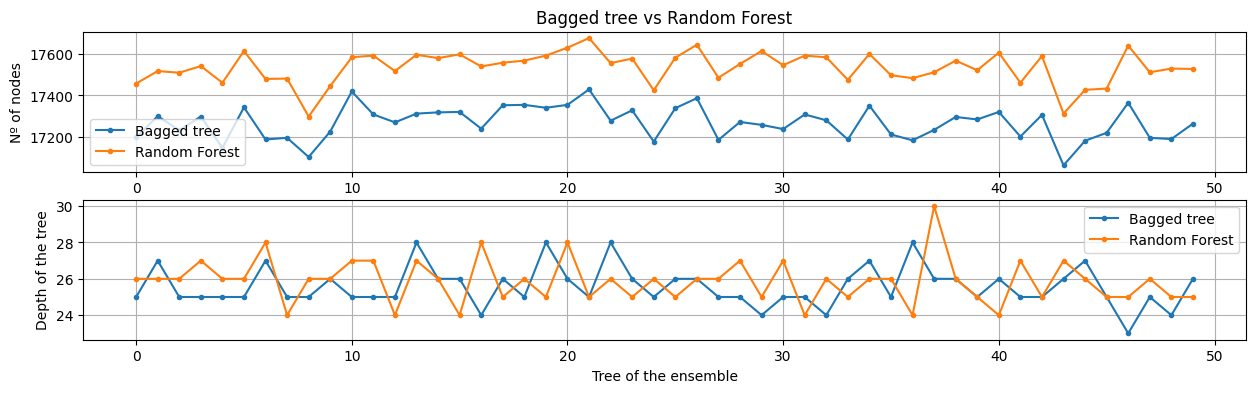

In [48]:
fig = plt.figure(1, figsize=(15, 4))
ax1=plt.subplot(2,1,1)
plt.plot(node_count_trees_bt, '.-', label ='Bagged tree')
plt.plot(node_count_trees_rf, '.-', label ='Random Forest')
plt.ylabel('Nº of nodes')     
plt.title('Bagged tree vs Random Forest') 
plt.legend()        
plt.grid()

plt.subplot(2,1,2, sharex = ax1)
plt.plot(depth_trees_bt, '.-', label ='Bagged tree')
plt.plot(depth_trees_rf, '.-', label ='Random Forest')
plt.ylabel('Depth of the tree')                       
plt.xlabel('Tree of the ensemble')                  
plt.grid()
plt.legend()        
plt.show()

###  Fit optimal Random Forest using Grid Search

In [49]:
# find optim nº of trees in the ensemble and max_features
param = {'RF__max_features': range(1, 6, 1), # Number number of features to consider when looking for the best split
         'RF__n_estimators': range(20, 150, 5)} # Number of trees in the forest

pipe =  Pipeline(steps=[('RF', 
                            RandomForestRegressor(n_estimators=number_estimators,
                                        max_features=m,
                                        criterion='squared_error',  # impurity measure
                                        min_samples_split=2, # Minimum number of obs in node to keep cutting
                                        min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                        random_state=0)
                        )])

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
rf_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
# fit the bagged trees
INPUTS_BT = INPUTS  
rf_fit.fit(X_train[INPUTS_BT], y_train) # Search in grid

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('RF',
                                        RandomForestRegressor(max_features='sqrt',
                                                              n_estimators=50,
                                                              random_state=0))]),
             n_jobs=-1,
             param_grid={'RF__max_features': range(1, 6),
                         'RF__n_estimators': range(20, 150, 5)})

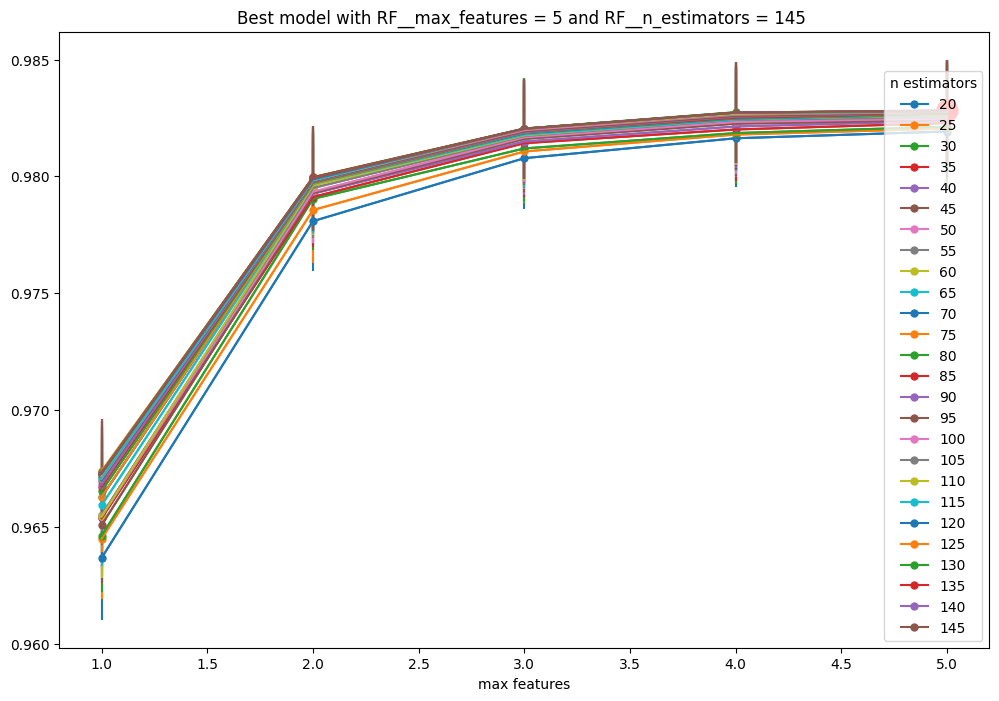

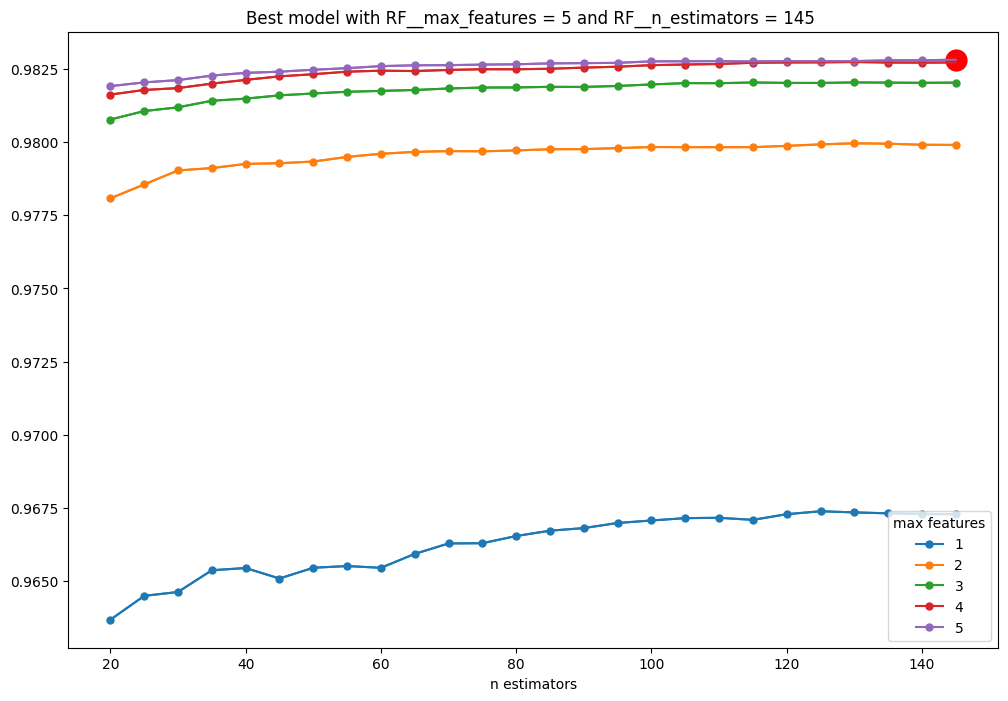

In [50]:
MT.plotModelGridError(rf_fit)

#### Compute errors of the forest

In [35]:
print('Random Forest')
y_train_est_RF2 =  rf_fit.predict(X_train)
y_test_est_RF2 =  rf_fit.predict(X_test)

mse_tr_RF2 = np.mean((y_train - y_train_est_RF2)**2)
mse_ts_RF2 = np.mean((y_test - y_test_est_RF2)**2)

mae_tr_RF2 = np.mean(np.abs(y_train - y_train_est_RF2))
mae_ts_RF2  = np.mean(np.abs(y_test - y_test_est_RF2))

print(f'MSE(TR) = {mse_tr_RF2}')
print(f'MSE(TS) = {mse_ts_RF2}')

print(f'MAE(TR) = {mae_tr_RF2}')
print(f'MAE(TS) = {mae_ts_RF2}')

r2_squared = metrics.r2_score(y_test, y_test_est_RF)
r2_squared


Random Forest
MSE(TR) = 0.00013869960759722128
MSE(TS) = 0.0009794309804353404
MAE(TR) = 0.005786077423549174
MAE(TS) = 0.01563908560988415


0.9802504341990762